<h1 style="text-align:center"> MCHE 485: Mechanical Vibrations</h1>
<h2 style="text-align:center">Mini-Project 2 <br> Spring 2018</h2>
<p style="text-align:center">Dr. Joshua Vaughan<br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/</p>

In some configurations, crane payloads can behave like double-pendulums. A planar model that captures this effect is sketched in Figure 1. In this model, the cables are assumed to be massless, inflexible, and inextensible. The main suspension cable (between the trolley and the hook) has a length of $l_1$, and the rigging (between the crane hook and payload) has a length of $l_2$. The hook has mass, $m_h$, and the payload has mass, $m_p$. The angles of the suspension cable and rigging cable are described by $\theta$ and $\phi$, respectively.

<p style="text-align:center">
	<img src="http://crawlab.org/shared/crane_doublePend.png" alt="Crane with Double-pendulum Payload" width=20%><br>
    <strong>Figure 1: Crane with Double-pendulum Payload</strong>
</p>

Most the data you have been given was generated via trolley motion, *residual* vibration (*i.e.* the vibration after the move is finished) can be treated as free vibration with initial conditions corresponding to those at the conclusion of the trolley motion. In this case, the crane model simplifies to the simple double-pendulum one shown in Figure 2. It is this model that you will develop and use in this mini-project.

<p style="text-align:center">
	<img src="http://crawlab.org/shared/fixed_doublePend.png" alt="Double-Pendulum" width=20%><br>
    <strong>Figure 2: Double-Pendulum</strong>
</p>


The data files in the repository are named to indicate the system parameters used when the data was collected. The filenames follow the naming convention:

     DoublePendulum_payloadMass_OptionalIdentifier.txt
     
For all of the files, the `DoublePendulum` portion of the filename will be the same. The parameter that does change is `payloadMass`. The `payloadMass` is either `normal` or `heavy`, corresponding to the two possible payloads captured in the data. The `OptionalIdentifier` is only present as necessary, to generate unique filenames. The `normal` payload mass is 22.7kg (50lbs) and the crane hook mass is 50kg ($m_h = 50$kg). For all data, the suspension cable length, $l_1$, was 3.5m.

There are three data files for the normal payload mass. Two represent approximately-3m moves of the crane. The other is an initial condition response. Use these to determine the unknown rigging length, $l_2$. Then, using the determined rigging length, and the `DoublePendulum_Heavy.txt` data file, determine the heavy payload mass.

In [1]:
import numpy as np
from scipy import signal

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
# This is the cell that will ask the user to select the data file. 
# It will open a "normal" file selection window.
import tkinter
from tkinter import filedialog

# Read in the text file to parse
root = tkinter.Tk()

# This line may need to be commented out in Windows
root.withdraw()

file_path = filedialog.askopenfilename()

# These two lines are needed to force the file dialog box to close
root.update()
root.destroy()

In [4]:
# Now, read in the data from the selected file
data = np.genfromtxt(file_path, delimiter=',')

# Definte a time vector
#  We know that he PLC updates at a 35ms cycle time
plc_refresh_rate = 0.035        
time = np.arange(0.0, len(data) * plc_refresh_rate, plc_refresh_rate)

# Trolley and Bridge positions and velocities
trolley_position = data[:,0] - data[0,0] # remove initial position to enable plotting from zero (relative position)
bridge_position = data[:,1] - data[0,1]  # remove initial position to enable plotting from zero (relative position)

trolley_velocity = data[:,2] 
bridge_velocity = data[:,3]

# Velocity commands issued to trolley and bridge
trolley_vel_command = data[:,4]
bridge_vel_command = data[:,5]

# Hook angles
hook_angle_tr = data[:,6]          
hook_angle_br = data[:,7]

# Define the cable length to the hook
L = 6.18 - data[:,12]

# Use the data from above to write the spatial position of the hook
pos_hk_tr = trolley_position + hook_angle_tr * np.pi/180 * L
pos_hk_br = bridge_position + hook_angle_br * np.pi/180 * L

In [5]:
# We'll use this function to smooth the data

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    
    From: http://wiki.scipy.org/Cookbook/SignalSmooth
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(), s, mode='valid')
    
    return y

In [6]:
# Now that we've defined the smoothing function, let's use it
window_size = 32
vib_smoothed = smooth(hook_angle_tr, window_size)

# We can also remove any nonzero trends in the data
vib_detrend = signal.detrend(vib_smoothed)

# Define a range to match the time vector, 
# adjusting for the change in size due to the smoothing window
vib_shifted = vib_detrend[(window_size//2):(len(time) + window_size//2)]

Let's plot the trolley motion the payload response to it.

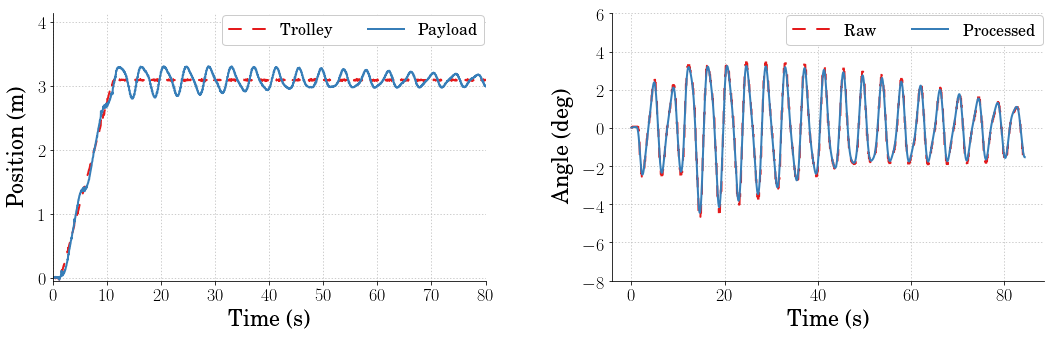

In [7]:
# Set the plot size - 3x2 aspect ratio is best 
#   - here we have two of those next to each other, so double the width
fig = plt.figure(figsize=(12,4))
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)

# Create a subplot for the trolley velocity command
plt.subplot(1,2,1)
ax = plt.gca()
# Change the axis units to CMU Serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)


plt.plot(time, trolley_position, linewidth=2, linestyle="--", label = 'Trolley')
plt.plot(time, pos_hk_tr, linewidth=2, label = r'Payload')

# uncomment below and set limits if needed
plt.xlim(0,80)
plt.ylim(1.5*np.min(pos_hk_tr), 1.25*np.max(pos_hk_tr))

# Create the legend, then fix the fontsize
leg = plt.legend(loc='best', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=16)


# Create a subplot for the payload angle
plt.subplot(1,2,2)
ax = plt.gca()
# Change the axis units to CMU Serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)',family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)',family='serif', fontsize=22, weight='bold', labelpad=10)

# uncomment below and set limits if needed
# plt.xlim(0, 150)
plt.ylim(np.floor(1.5*np.min(hook_angle_tr)), np.ceil(1.5*np.max(hook_angle_tr)))


plt.plot(time, hook_angle_tr,linewidth=2, linestyle="--", label=r'Raw')
plt.plot(time, vib_shifted, linewidth=2, label=r'Processed')

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(w_pad=2.0)

fig.set_size_inches(15,5) # Resize the figure for better display in the notebook

**Note:**    
This is the main place that you'll have to modify this notebook for this mini-project. You should trim the response such that only the free vibration portion is being analyzed. For example, in the plot above, you'd want to trim approximately the first 3 seconds from the beginning of the response. You'll want to trim the <span><tt>vib_shifted</tt></span> array.

For help in trimming NumPy arrays, see the [SciPy Lecture Notes](https://scipy-lectures.github.io/intro/numpy/array_object.html#indexing-and-slicing).

In the code block below, one way to do this is demonstrated. The user (*i.e.* you) needs to specify the time range of the free vibration portion of the response, using the `freeVib_time_start` variable to define its start time and `freeVib_time_end` variables. These are then used to find the index of the time array that most closely matches those times. Uses those two indices, the `time` and `vib_shifted` arrays are trimmed and saved to `time_clipped` and `vib_data`, respectively. These new arrays should contain only the free vibration part of the response. We also take the extra step of re-centering the response around zero, again using the `signal.detrend()` function.

In [8]:
freeVib_time_start = 20    # Time that the free vibration part of the response begins
freeVib_time_end = 80      # Time the the free vibration part of the response ends

# Find the index in the time array that is closest to the start and end times of the region. 
# We just look for the index where the difference is minimized.
index_start = np.argmin(np.abs(time - freeVib_time_start))
index_end = np.argmin(np.abs(time - freeVib_time_end))

# Now, using those indieces, we create new arrays containing the clipped region
time_freeVib = time[index_start:index_end]

# For the vibration data, we also detrend it again, based on the new range
freeVib_data = signal.detrend(vib_shifted[index_start:index_end])

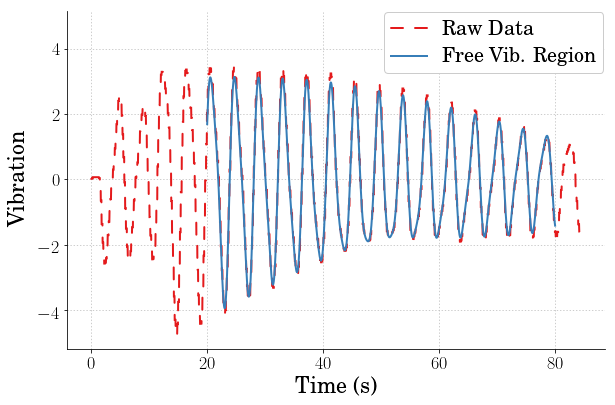

In [9]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vibration', family='serif', fontsize=22, weight='bold', labelpad=10)

plt.plot(time, hook_angle_tr, linewidth=2, linestyle="--", label=r'Raw Data')
plt.plot(time_freeVib, freeVib_data, linewidth=2, linestyle='-', label=r'Free Vib. Region')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(ymax=1.5 * np.max((np.max(hook_angle_tr), np.max(hook_angle_tr))))

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('free_vibration_region.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

# System Characterization/System ID
Because this is a multi-mode system, timing zero-crossings or using log dec would not give the correct results. Here, we'll rely on the FFT. We expect to see two dominiant osciallatory modes.

In [10]:
# You should not need to change anything in this cell. I've defined a "convenient" version of the FFT for you to use.

def CRAWLAB_fft(data, time, plotflag):
    ''' Function to get the FFT for a response
    #
    # Inputs:
    #   time = time array corresponding to the data
    #   data = the response data array (only pass a single dimension/state at at time)
    #   plotflag = will plot the FFT if nonzero
    #   
    # Output:
    #   fft_freq = an array of the freqs used in the FFT
    #   fft_mag = an array of the amplitude of the FFT at each freq in fft_freq
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    #
    # Modified:
    #   * 03/17/16 - JEV - joshua.vaughan@louisiana.edu
    #       - updated for Python 3
    ######################################################################################
    '''
    
    from scipy.fftpack import fft
    
    # correct for any DC offset
    offset = np.mean(data) 

    # Get the sampling time
    sample_time = time[1] - time[0]
    
    # Get the length of the dataset
    n = len(data)

    # Calculate the FFT of the data, removing the offset and using a Hanning Window
    fft_mag = fft((data - offset) * np.hanning(len(data)))
    
    # Define the frequency range of the output
    fft_freq = np.linspace(0.0, 1.0 / (2.0*sample_time), int(np.ceil(n/2)))
    
    # Only return the "useful" part of the fft
    fft_mag = 2.0/n * np.abs(fft_mag[0:int(np.ceil(n/2))])
    
    # If plotflag is nonzero (True), plot the FFT before returning the magnitude and phase
    if plotflag:
        # Plot the relationshiop
        #   Many of these setting could also be made default by the .matplotlibrc file
        fig = plt.figure(figsize=(6,4))
        ax = plt.gca()
        plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
        plt.setp(ax.get_ymajorticklabels(),fontsize=18)
        plt.setp(ax.get_xmajorticklabels(),fontsize=18)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.grid(True, linestyle=':', color='0.75')
        ax.set_axisbelow(True)

        plt.xlabel('Frequency (Hz)', fontsize=22, labelpad=8)
        plt.ylabel('FFT magnitude', fontsize=22, labelpad=10)
    
        plt.plot(fft_freq, fft_mag, linewidth=2, linestyle='-')
        
        # Adjust the page layout filling the page using the new tight_layout command
        plt.tight_layout(pad=0.5)
        plt.show()
    
    return fft_freq, fft_mag

Now, we'll use the FFT function I defined to actually calculate and plot the FFT. The code below finds the two highest magnitude peaks, through a very "quick-and-dirty" approach. You should check the results to make sure they match the plot.


The highest magnitude peak occurs at 0.2490 Hz.

The second-highest magnitude peak occurs at 0.4742 Hz.



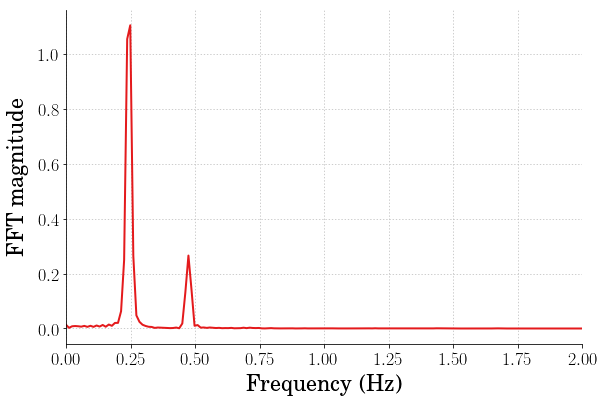

In [11]:
# Use the FFT to get the natrual frequency
freq, mag = CRAWLAB_fft(vib_detrend[window_size-2:-1],time,False)

# Let's plot the FFT manually so that we can scale the axes to our liking

# Plot the relationshiop
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),fontsize=18)
plt.setp(ax.get_xmajorticklabels(),fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Frequency (Hz)',fontsize=22,labelpad=8)
plt.ylabel('FFT magnitude',fontsize=22,labelpad=10)

plt.plot(freq, mag, linewidth=2, linestyle='-')
plt.xlim(0, 2)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# plt.savefig('FFT_magnitude.pdf',dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook


# --- Now find the 2 highest peaks in the FFT magnitude 
#
# Output the location of the highest peak - The fundamental frequency
freq_index = np.argmax(mag)

# Now, get the 2nd highest peak - This should tell us the 2nd frequency
#
# NOTE: this is a very hack way of doing it. We just ignore the main peak and 2 indices on either side.
#       You are likely to have to adjust in order for it to work for all responses
mag_minus_max = mag
mag_minus_max[freq_index-2:freq_index+2] = 0
freq_index2 = np.argmax(mag_minus_max)

print('\nThe highest magnitude peak occurs at {:.4f} Hz.'.format(freq[freq_index]))
print('\nThe second-highest magnitude peak occurs at {:.4f} Hz.\n'.format(freq[freq_index2]))

We could also take the FFT of the position data. For the cases where the crane moved, we should see a significant contribution from the  rigid-boby mode (*i.e.* A high-magnitude at $\omega = 0$.).

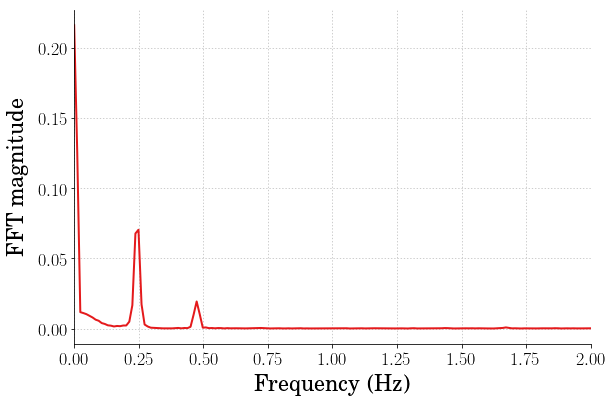

In [12]:
# We can also use the FFT to get the natrual frequency
freq, mag = CRAWLAB_fft(pos_hk_tr, time, False)

# Let's plot the FFT manually so that we can scale the axes to our liking

# Plot the relationshiop
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),fontsize=18)
plt.setp(ax.get_xmajorticklabels(),fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Frequency (Hz)',fontsize=22,labelpad=8)
plt.ylabel('FFT magnitude',fontsize=22,labelpad=10)

plt.plot(freq, mag, linewidth=2, linestyle='-')
plt.xlim(0, 2)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# plt.savefig('FFT_magnitude.pdf',dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

The plot does have a peak at zero frequency, reflecting the existence of the rigid-body mode.

<hr style="border: 0px;
        height: 1px;
        text-align: center;
        background: #333;
        background-image: -webkit-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:    -moz-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:     -ms-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:      -o-linear-gradient(left, #ccc, #333, #ccc);">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.


In [13]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))